# Swing Trading Analysis (2-3 Months)

Strategy:
- **Focus**: Technical patterns, momentum, entry/exit timing
- **Timeframe**: 2-3 months
- **Target**: 10-20% gains
- **Risk**: Medium

In [ ]:
# Setup imports
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from data_fetcher import StockDataFetcher
from indicators import (sma, ema, rsi, macd, bollinger_bands, 
                        adx, atr, stochastic, cci, mfi, cmf, 
                        supertrend, keltner_channels, roc, obv, vwap, 
                        keltner_channels, ichimoku_cloud, squeeze_momentum)

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print('Swing Trading Analysis Setup Complete')

Extended indicators module loaded
Swing Trading Analysis Setup Complete


In [ ]:
fetcher = StockDataFetcher()

# Change this ticker to analyze a different stock
ticker = 'AMZN'

# Fetch 2 years of data 
df = fetcher.fetch(ticker, period='2y')

print(f"\nFirst 5 rows of {ticker} data:")
df.head()

Fetching AAPL data...
Got 502 days of data

First 5 rows of AAPL data:


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-10-23 00:00:00-04:00,169.252191,172.322112,168.281686,171.321915,55980100,0.0,0.0
2023-10-24 00:00:00-04:00,171.371428,171.985409,169.786942,171.757645,43816600,0.0,0.0
2023-10-25 00:00:00-04:00,170.212771,171.381318,168.994691,169.440338,57157000,0.0,0.0
2023-10-26 00:00:00-04:00,168.717435,169.717648,164.063027,165.271194,70625300,0.0,0.0
2023-10-27 00:00:00-04:00,165.290997,167.321115,165.211771,166.588287,58499100,0.0,0.0


## Add Technical Indicators

We'll add indicators focused on 2-3 month swings:
- Moving Averages (20, 50 day)
- RSI (overbought/oversold)
- MACD (momentum)
- Bollinger Bands (volatility)

In [3]:
# Cell 3: Calculate All Indicators

# Basic Moving Averages
df['SMA_20'] = sma(df['Close'], 20)
df['SMA_50'] = sma(df['Close'], 50)
df['SMA_200'] = sma(df['Close'], 200)
df['EMA_12'] = ema(df['Close'], 12)
df['EMA_26'] = ema(df['Close'], 26)

# Momentum Indicators
df['RSI_14'] = rsi(df['Close'], 14)
df['CCI_20'] = cci(df['High'], df['Low'], df['Close'], 20)
df['ROC_10'] = roc(df['Close'], 10)

stoch = stochastic(df['High'], df['Low'], df['Close'], 14, 3)
df['Stoch_K'] = stoch['K']
df['Stoch_D'] = stoch['D']

macd_data = macd(df['Close'], 12, 26, 9)
df['MACD'] = macd_data['MACD']
df['MACD_Signal'] = macd_data['Signal']
df['MACD_Hist'] = macd_data['Histogram']

# Trend Strength
adx_data = adx(df['High'], df['Low'], df['Close'], 14)
df['ADX'] = adx_data['ADX']
df['Plus_DI'] = adx_data['Plus_DI']
df['Minus_DI'] = adx_data['Minus_DI']

# SuperTrend
supertrend_data = supertrend(df['High'], df['Low'], df['Close'], 10, 3)
df['SuperTrend'] = supertrend_data['SuperTrend']
df['SuperTrend_Direction'] = supertrend_data['Direction']

# Volatility
df['ATR_14'] = atr(df['High'], df['Low'], df['Close'], 14)

bb = bollinger_bands(df['Close'], 20, 2)
df['BB_Upper'] = bb['Upper']
df['BB_Middle'] = bb['Middle']
df['BB_Lower'] = bb['Lower']

kc = keltner_channels(df['High'], df['Low'], df['Close'], 20, 10, 2)
df['KC_Upper'] = kc['Upper']
df['KC_Middle'] = kc['Middle']
df['KC_Lower'] = kc['Lower']

# Volume Indicators
df['OBV'] = obv(df['Close'], df['Volume'])
df['MFI_14'] = mfi(df['High'], df['Low'], df['Close'], df['Volume'], 14)
df['CMF_20'] = cmf(df['High'], df['Low'], df['Close'], df['Volume'], 20)
df['VWAP'] = vwap(df['High'], df['Low'], df['Close'], df['Volume'])

# Volume Analysis
df['Volume_SMA_20'] = df['Volume'].rolling(window=20).mean()
df['Volume_Ratio'] = df['Volume'] / df['Volume_SMA_20']

# Volatility Regime (FIXED - Adaptive window)
returns = df['Close'].pct_change()
df['Historical_Vol_20'] = returns.rolling(window=20).std() * np.sqrt(252)

# Adaptive window for Vol_Percentile to prevent data loss
data_length = len(df)
vol_window = min(data_length - 200, 120)  # Use smaller window if insufficient data

if vol_window >= 20:
    df['Vol_Percentile'] = df['Historical_Vol_20'].rolling(window=vol_window).apply(
        lambda x: pd.Series(x).rank(pct=True).iloc[-1]
    )
else:
    # Fallback: just use simple percentile without rolling
    df['Vol_Percentile'] = 0.5  # Neutral value

# Price Structure
df['Higher_High'] = df['High'] > df['High'].shift(1)
df['Lower_Low'] = df['Low'] < df['Low'].shift(1)

# Squeeze Momentum Detection
df['Squeeze_On'] = squeeze_momentum(df['High'], df['Low'], df['Close'], bb_length=20, kc_length=20)

# Remove rows with NaN values from indicator calculation
df = df.dropna()

print(f"Data prepared: {len(df)} bars available for analysis")
print(f"Date range: {df.index[0].date()} to {df.index[-1].date()}")
print("\nFirst 5 rows of calculated indicators:")
print(df[['Close', 'RSI_14', 'ADX', 'MFI_14', 'VWAP', 'Squeeze_On']].head())

Data prepared: 303 bars available for analysis
Date range: 2024-08-08 to 2025-10-22

First 5 rows of calculated indicators:
                                Close     RSI_14        ADX     MFI_14  \
Date                                                                     
2024-08-08 00:00:00-04:00  212.076385  35.309864  40.099766  47.889672   
2024-08-09 00:00:00-04:00  214.989441  40.354842  41.902081  47.375878   
2024-08-12 00:00:00-04:00  216.522293  41.078865  43.652223  52.195638   
2024-08-13 00:00:00-04:00  220.244995  53.951373  44.544694  58.920791   
2024-08-14 00:00:00-04:00  220.692871  56.032560  43.370394  64.938441   

                                 VWAP  Squeeze_On  
Date                                               
2024-08-08 00:00:00-04:00  189.258563       False  
2024-08-09 00:00:00-04:00  189.342667       False  
2024-08-12 00:00:00-04:00  189.426552        True  
2024-08-13 00:00:00-04:00  189.534590        True  
2024-08-14 00:00:00-04:00  189.639103        

## Step 3: Generate Trading Signal

Analyze current conditions and generate BUY/SELL/HOLD signal

In [4]:
def detect_market_regime(df):
    """Identify market trend and volatility regime - FIXED VERSION"""
    current = df.iloc[-1]
    
    # Use ADX + Directional Indicators for trend (not SMA slope)
    if current['ADX'] > 25:
        if current['Plus_DI'] > current['Minus_DI']:
            trend_regime = "UPTREND"
        else:
            trend_regime = "DOWNTREND"
    elif current['ADX'] < 20:
        trend_regime = "RANGING"
    else:
        trend_regime = "TRANSITIONING"  # ADX 20-25, unclear
    
    # Volatility regime unchanged
    if current['Vol_Percentile'] > 0.7:
        vol_regime = "HIGH_VOL"
    elif current['Vol_Percentile'] < 0.3:
        vol_regime = "LOW_VOL"
    else:
        vol_regime = "NORMAL_VOL"
    
    return trend_regime, vol_regime


def calculate_improved_score(df):
    """
    Evidence-based scoring with proper weighting - IMPROVED VERSION
    Score range: -15 to +15
    """
    current = df.iloc[-1]
    score = 0
    signals = []
    
    # 1. TREND - Highest weight
    if current['ADX'] > 25:
        if current['SuperTrend_Direction'] == 1:
            score += 5
            signals.append(f"Strong uptrend (ADX: {current['ADX']:.1f})")
        else:
            score -= 5
            signals.append(f"Strong downtrend (ADX: {current['ADX']:.1f})")
    elif current['ADX'] > 20:
        if current['SuperTrend_Direction'] == 1:
            score += 3
            signals.append(f"Moderate uptrend (ADX: {current['ADX']:.1f})")
        else:
            score -= 3
            signals.append(f"Moderate downtrend (ADX: {current['ADX']:.1f})")
    
    # 2. MOMENTUM CONFLUENCE
    oversold_count = 0
    overbought_count = 0
    
    if current['RSI_14'] < 30:
        oversold_count += 1
    elif current['RSI_14'] > 70:
        overbought_count += 1
    
    if current['Stoch_K'] < 20 and current['Stoch_D'] < 20:
        oversold_count += 1
    elif current['Stoch_K'] > 80 and current['Stoch_D'] > 80:
        overbought_count += 1
    
    if current['MFI_14'] < 20:
        oversold_count += 1
    elif current['MFI_14'] > 80:
        overbought_count += 1
    
    if oversold_count >= 2:
        score += 3 + oversold_count
        signals.append(f"Multiple oversold signals ({oversold_count}/3)")
    elif overbought_count >= 2:
        score -= (3 + overbought_count)
        signals.append(f"Multiple overbought signals ({overbought_count}/3)")
    
    # 3. VOLUME CONFIRMATION
    if current['Volume_Ratio'] > 1.5:
        if current['CMF_20'] > 0.1:
            score += 2
            signals.append(f"High volume with buying pressure (Vol: {current['Volume_Ratio']:.1f}x)")
        elif current['CMF_20'] < -0.1:
            score -= 2
            signals.append(f"High volume with selling pressure (Vol: {current['Volume_Ratio']:.1f}x)")
    
    # 4. PRICE STRUCTURE
    if current['Close'] > current['SMA_20'] > current['SMA_50'] > current['SMA_200']:
        score += 3
        signals.append("Perfect bullish MA alignment")
    elif current['Close'] < current['SMA_20'] < current['SMA_50'] < current['SMA_200']:
        score -= 3
        signals.append("Perfect bearish MA alignment")
    elif current['Close'] > current['SMA_20'] > current['SMA_50']:
        score += 2
        signals.append("Bullish short-term structure")
    elif current['Close'] < current['SMA_20'] < current['SMA_50']:
        score -= 2
        signals.append("Bearish short-term structure")
    
    # 5. PRICE vs VWAP (NEW - Mean Reversion Signal)
    vwap_deviation = (current['Close'] - current['VWAP']) / current['VWAP']
    
    if abs(vwap_deviation) > 0.03:  # More than 3% from VWAP
        if vwap_deviation > 0:  # Overextended above VWAP
            score -= 2
            signals.append(f"Overextended vs VWAP (+{vwap_deviation*100:.1f}%)")
        else:  # Oversold vs VWAP
            score += 2
            signals.append(f"Undervalued vs VWAP ({vwap_deviation*100:.1f}%)")
    
    # 6. SQUEEZE DETECTION (NEW - Avoid Low-Volatility Traps)
    if current['Squeeze_On']:
        score -= 2
        signals.append("Squeeze active - avoid breakout traps")
    
    # 7. MACD (Reduced to confirmation only)
    if current['MACD'] > current['MACD_Signal'] and current['MACD_Hist'] > 0:
        score += 1
        signals.append("MACD bullish")
    elif current['MACD'] < current['MACD_Signal'] and current['MACD_Hist'] < 0:
        score -= 1
        signals.append("MACD bearish")
    
    # 8. VOLATILITY ADJUSTMENT
    if current['Vol_Percentile'] > 0.8:
        score *= 0.7
        signals.append("High volatility - reduced conviction")
    
    return score, signals


def calculate_risk_reward(df):
    """Calculate risk/reward ratio for position"""
    current = df.iloc[-1]
    atr = current['ATR_14']
    entry = current['Close']
    stop_loss = entry - (2 * atr)
    
    recent_high = df['High'].tail(20).max()
    target = recent_high
    
    risk = entry - stop_loss
    reward = target - entry
    rr_ratio = reward / risk if risk > 0 else 0
    
    return {
        'entry': entry,
        'stop': stop_loss,
        'target': target,
        'risk': risk,
        'reward': reward,
        'ratio': rr_ratio
    }


def calculate_position_size(account_size, risk_pct, risk_dollars):
    """Calculate proper position size"""
    account_risk = account_size * risk_pct
    shares = int(account_risk / risk_dollars) if risk_dollars > 0 else 0
    return shares


# Main Analysis
if len(df) < 50:
    print("ERROR: Insufficient data for analysis")
    print(f"Current data points: {len(df)}")
else:
    current = df.iloc[-1]
    
    # Market Regime
    trend_regime, vol_regime = detect_market_regime(df)
    
    # Calculate Score
    score, signals = calculate_improved_score(df)
    
    # Risk/Reward
    rr = calculate_risk_reward(df)
    
    # Analysis Output
    print("="*70)
    print(f"SWING TRADING ANALYSIS: {ticker}")
    print("="*70)
    
    print(f"\nCurrent Price: ${current['Close']:.2f}")
    print(f"VWAP: ${current['VWAP']:.2f} (Deviation: {((current['Close']-current['VWAP'])/current['VWAP']*100):+.1f}%)")
    print(f"ATR (14): ${current['ATR_14']:.2f} ({current['ATR_14']/current['Close']*100:.1f}%)")
    
    # NEW SECTION: Key Metrics (Always Displayed)
    print("\n" + "="*70)
    print("KEY METRICS")
    print("="*70)
    
    print(f"RSI (14): {current['RSI_14']:.1f}", end="")
    if current['RSI_14'] > 70:
        print(" [OVERBOUGHT]")
    elif current['RSI_14'] < 30:
        print(" [OVERSOLD]")
    else:
        print(" [NEUTRAL]")
    
    print(f"Stochastic: %K={current['Stoch_K']:.1f}, %D={current['Stoch_D']:.1f}", end="")
    if current['Stoch_K'] > 80 and current['Stoch_D'] > 80:
        print(" [OVERBOUGHT]")
    elif current['Stoch_K'] < 20 and current['Stoch_D'] < 20:
        print(" [OVERSOLD]")
    else:
        print(" [NEUTRAL]")
    
    print(f"MFI (14): {current['MFI_14']:.1f}", end="")
    if current['MFI_14'] > 80:
        print(" [OVERBOUGHT]")
    elif current['MFI_14'] < 20:
        print(" [OVERSOLD]")
    else:
        print(" [NEUTRAL]")
    
    print(f"CCI (20): {current['CCI_20']:.1f}", end="")
    if current['CCI_20'] > 100:
        print(" [OVERBOUGHT]")
    elif current['CCI_20'] < -100:
        print(" [OVERSOLD]")
    else:
        print(" [NEUTRAL]")
    
    print(f"CMF (20): {current['CMF_20']:.3f}", end="")
    if current['CMF_20'] > 0.1:
        print(" [BUYING PRESSURE]")
    elif current['CMF_20'] < -0.1:
        print(" [SELLING PRESSURE]")
    else:
        print(" [NEUTRAL]")
    
    print(f"Volume Ratio: {current['Volume_Ratio']:.2f}x", end="")
    if current['Volume_Ratio'] > 1.5:
        print(" [HIGH VOLUME]")
    elif current['Volume_Ratio'] < 0.5:
        print(" [LOW VOLUME]")
    else:
        print(" [NORMAL]")
    
    print(f"Squeeze: {'ACTIVE' if current['Squeeze_On'] else 'OFF'}", end="")
    if current['Squeeze_On']:
        print(" [COMPRESSION]")
    else:
        print(" [NORMAL]")
    
    print("\n" + "="*70)
    print("MARKET REGIME")
    print("="*70)
    print(f"Trend: {trend_regime}")
    print(f"Volatility: {vol_regime}")
    
    # Strategy recommendations
    if trend_regime == "RANGING":
        print("Strategy: Mean reversion preferred")
    elif trend_regime == "UPTREND":
        print("Strategy: Trend following on pullbacks")
    elif trend_regime == "DOWNTREND":
        print("Strategy: Reduce exposure or short bias")
    elif trend_regime == "TRANSITIONING":
        print("Strategy: Wait for clearer trend direction")
    
    if vol_regime == "HIGH_VOL":
        print("Risk Adjustment: Reduce position sizes by 50%")
    
    print("\n" + "="*70)
    print("TECHNICAL SCORE")
    print("="*70)
    
    # STRICTER SIGNAL THRESHOLDS
    if score >= 8 and rr['ratio'] >= 2.5:
        signal_text = "STRONG BUY"
    elif score >= 6 and rr['ratio'] >= 2.0:
        signal_text = "BUY"
    elif score <= -8 and rr['ratio'] >= 2.5:
        signal_text = "STRONG SELL"
    elif score <= -6 and rr['ratio'] >= 2.0:
        signal_text = "SELL"
    else:
        signal_text = "NO TRADE"
    
    print(f"\nSignal: {signal_text}")
    print(f"Score: {score:.1f}/15")
    print(f"R:R Ratio: {rr['ratio']:.2f}:1")
    
    if signal_text == "NO TRADE":
        if rr['ratio'] < 2.0:
            print("Reason: Poor risk/reward ratio")
        elif score < 6 and score > -6:
            print("Reason: Insufficient technical score")
        else:
            print("Reason: Both score and R:R requirements not met")
    
    print("\nSignal Components:")
    for i, signal in enumerate(signals, 1):
        print(f"  {i}. {signal}")
    
    print("\n" + "="*70)
    print("RISK/REWARD ANALYSIS")
    print("="*70)
    print(f"Entry: ${rr['entry']:.2f}")
    print(f"Stop Loss: ${rr['stop']:.2f}")
    print(f"Target: ${rr['target']:.2f}")
    print(f"Risk: ${rr['risk']:.2f}")
    print(f"Reward: ${rr['reward']:.2f}")
    print(f"R:R Ratio: {rr['ratio']:.2f}:1")
    
    if rr['ratio'] < 2:
        print("\nWARNING: Poor risk/reward ratio. Trade rejected.")
    
    print("\n" + "="*70)
    print("POSITION SIZING")
    print("="*70)
    
    if signal_text != "NO TRADE":
        account_size = 100000
        risk_pct = 0.01
        shares = calculate_position_size(account_size, risk_pct, rr['risk'])
        capital_required = shares * rr['entry']
        
        print(f"Account Size: ${account_size:,.0f}")
        print(f"Risk Per Trade: {risk_pct*100:.1f}%")
        print(f"Shares: {shares}")
        print(f"Capital Required: ${capital_required:,.0f}")
        
        if vol_regime == "HIGH_VOL":
            print(f"Adjusted Shares (50% reduction): {int(shares * 0.5)}")
    else:
        print("Position sizing skipped - no valid trade signal")


SWING TRADING ANALYSIS: AAPL

Current Price: $257.32
VWAP: $208.37 (Deviation: +23.5%)
ATR (14): $5.51 (2.1%)

KEY METRICS
RSI (14): 50.2 [NEUTRAL]
Stochastic: %K=62.6, %D=80.1 [NEUTRAL]
MFI (14): 49.3 [NEUTRAL]
CCI (20): 75.5 [NEUTRAL]
CMF (20): 0.089 [NEUTRAL]
Volume Ratio: 0.68x [NORMAL]
Squeeze: ACTIVE [COMPRESSION]

MARKET REGIME
Trend: DOWNTREND
Volatility: NORMAL_VOL
Strategy: Reduce exposure or short bias

TECHNICAL SCORE

Signal: NO TRADE
Score: 3.0/15
R:R Ratio: 0.72:1
Reason: Poor risk/reward ratio

Signal Components:
  1. Strong uptrend (ADX: 35.8)
  2. Perfect bullish MA alignment
  3. Overextended vs VWAP (+23.5%)
  4. Squeeze active - avoid breakout traps
  5. MACD bearish

RISK/REWARD ANALYSIS
Entry: $257.32
Stop Loss: $246.29
Target: $265.29
Risk: $11.03
Reward: $7.97
R:R Ratio: 0.72:1


POSITION SIZING
Position sizing skipped - no valid trade signal


/var/folders/w_/28vmrqyd06nfgfmd8dl89ccm0000gn/T/ipykernel_20648/1581111304.py:5: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent = df.last('180D')



Chart saved to results/swing_trading_analysis.png


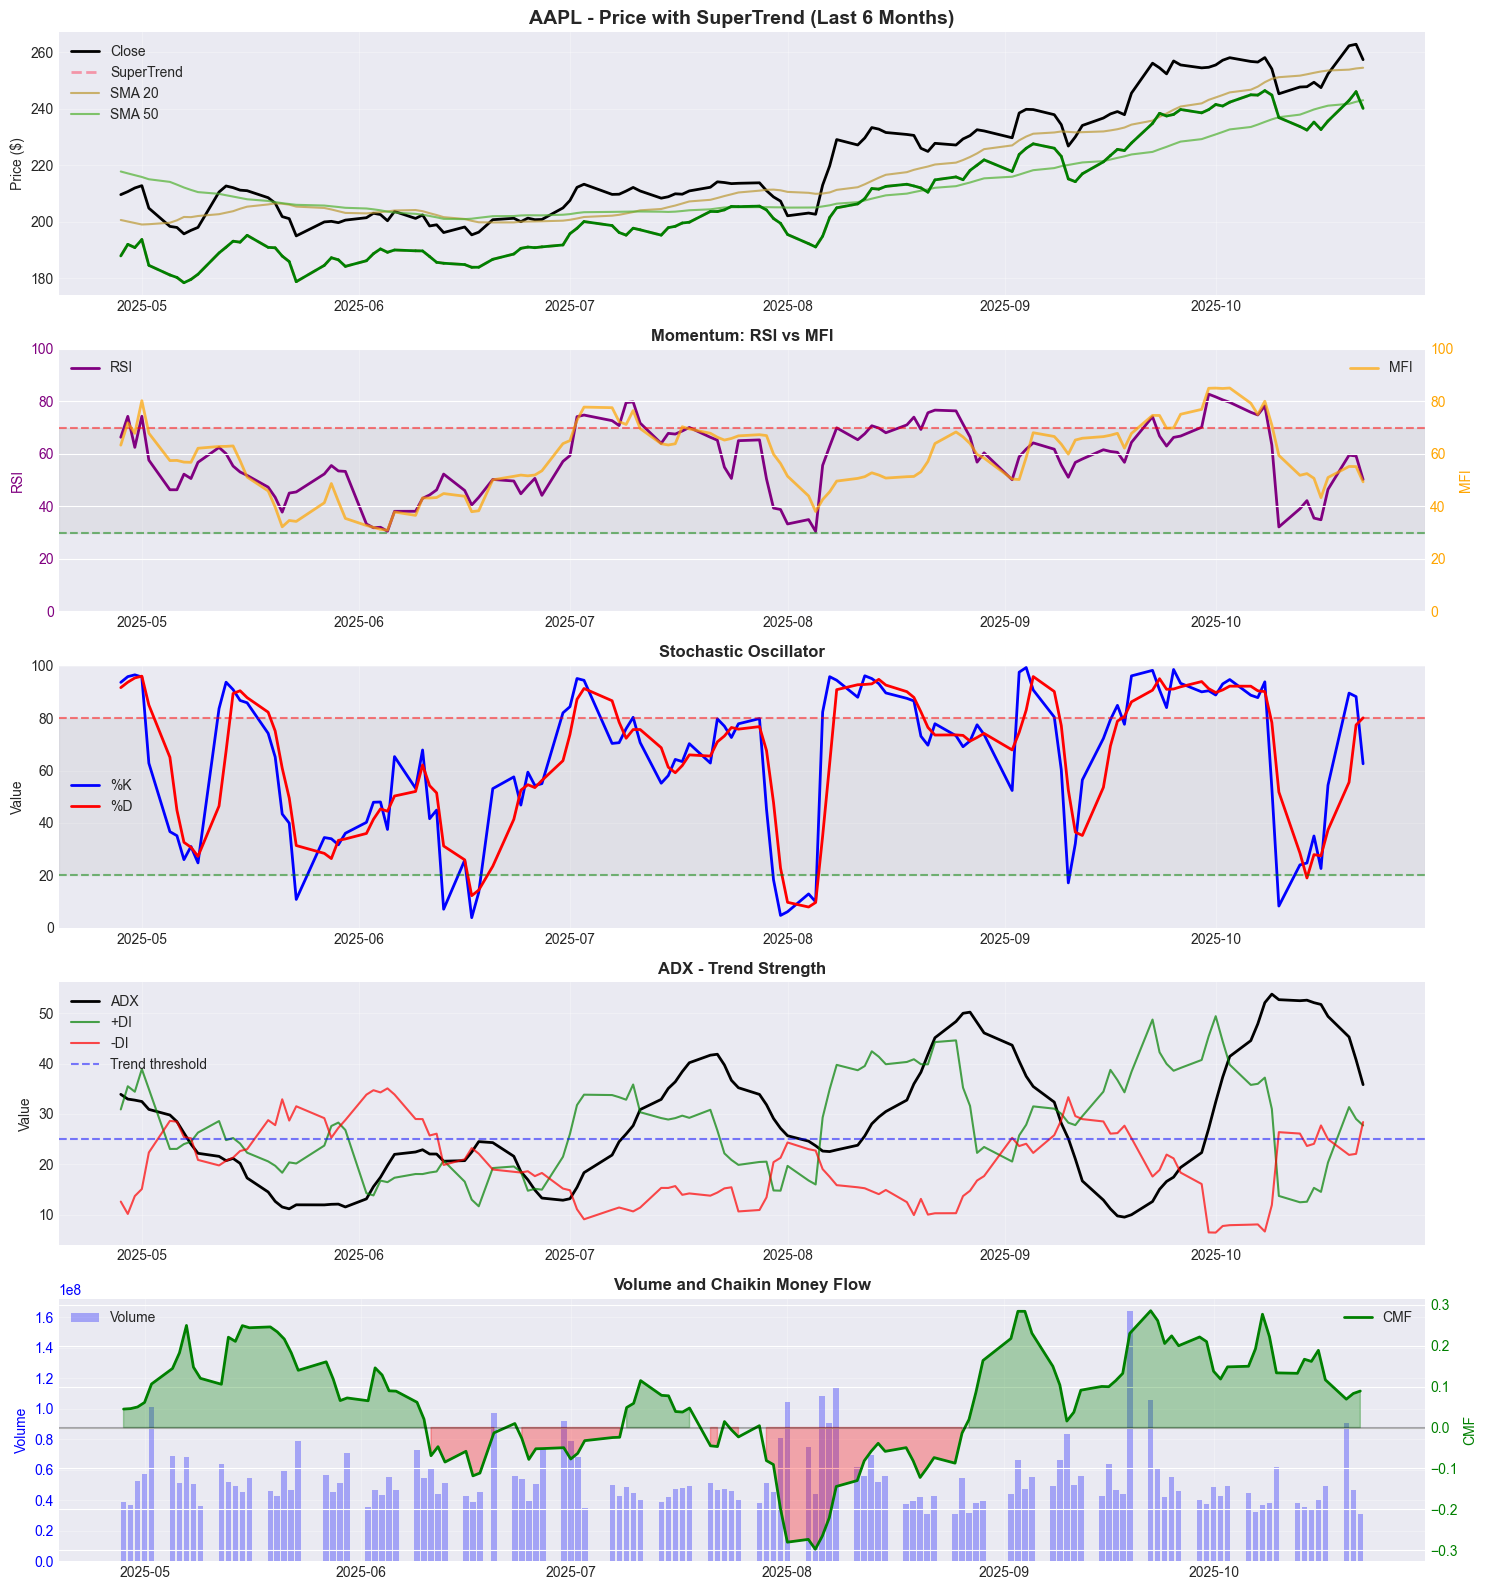

In [5]:
# Create comprehensive chart
fig, axes = plt.subplots(5, 1, figsize=(15, 16))

# Get last 6 months for cleaner view
recent = df.last('180D')

# Chart 1: Price with SuperTrend and Moving Averages
axes[0].plot(recent.index, recent['Close'], label='Close', linewidth=2, color='black')
axes[0].plot(recent.index, recent['SuperTrend'], label='SuperTrend', 
             linewidth=2, linestyle='--', alpha=0.7)
axes[0].plot(recent.index, recent['SMA_20'], label='SMA 20', linewidth=1.5, alpha=0.7)
axes[0].plot(recent.index, recent['SMA_50'], label='SMA 50', linewidth=1.5, alpha=0.7)

# Color SuperTrend based on direction
for i in range(1, len(recent)):
    if recent['SuperTrend_Direction'].iloc[i] == 1:
        axes[0].plot(recent.index[i-1:i+1], recent['SuperTrend'].iloc[i-1:i+1], 
                    color='green', linewidth=2)
    else:
        axes[0].plot(recent.index[i-1:i+1], recent['SuperTrend'].iloc[i-1:i+1], 
                    color='red', linewidth=2)

axes[0].set_title(f'{ticker} - Price with SuperTrend (Last 6 Months)', 
                  fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price ($)')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# Chart 2: RSI and MFI - FIXED
ax2a = axes[1]
ax2b = ax2a.twinx()

ax2a.plot(recent.index, recent['RSI_14'], color='purple', linewidth=2, label='RSI')
ax2a.axhline(y=70, color='r', linestyle='--', alpha=0.5)
ax2a.axhline(y=30, color='g', linestyle='--', alpha=0.5)
ax2a.axhspan(30, 70, alpha=0.1, color='gray')  # FIXED - use axhspan
ax2a.set_ylabel('RSI', color='purple')
ax2a.set_ylim(0, 100)
ax2a.tick_params(axis='y', labelcolor='purple')

ax2b.plot(recent.index, recent['MFI_14'], color='orange', linewidth=2, label='MFI', alpha=0.7)
ax2b.set_ylabel('MFI', color='orange')
ax2b.set_ylim(0, 100)
ax2b.tick_params(axis='y', labelcolor='orange')

axes[1].set_title('Momentum: RSI vs MFI', fontsize=12, fontweight='bold')
ax2a.legend(loc='upper left')
ax2b.legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

# Chart 3: Stochastic - FIXED
axes[2].plot(recent.index, recent['Stoch_K'], label='%K', linewidth=2, color='blue')
axes[2].plot(recent.index, recent['Stoch_D'], label='%D', linewidth=2, color='red')
axes[2].axhline(y=80, color='r', linestyle='--', alpha=0.5)
axes[2].axhline(y=20, color='g', linestyle='--', alpha=0.5)
axes[2].axhspan(20, 80, alpha=0.1, color='gray')  # FIXED - use axhspan
axes[2].set_title('Stochastic Oscillator', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Value')
axes[2].set_ylim(0, 100)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# Chart 4: ADX and Directional Movement
axes[3].plot(recent.index, recent['ADX'], label='ADX', linewidth=2, color='black')
axes[3].plot(recent.index, recent['Plus_DI'], label='+DI', linewidth=1.5, alpha=0.7, color='green')
axes[3].plot(recent.index, recent['Minus_DI'], label='-DI', linewidth=1.5, alpha=0.7, color='red')
axes[3].axhline(y=25, color='blue', linestyle='--', alpha=0.5, label='Trend threshold')
axes[3].set_title('ADX - Trend Strength', fontsize=12, fontweight='bold')
axes[3].set_ylabel('Value')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

# Chart 5: Volume with CMF
ax5a = axes[4]
ax5b = ax5a.twinx()

ax5a.bar(recent.index, recent['Volume'], alpha=0.3, color='blue', label='Volume')
ax5a.set_ylabel('Volume', color='blue')
ax5a.tick_params(axis='y', labelcolor='blue')

ax5b.plot(recent.index, recent['CMF_20'], color='green', linewidth=2, label='CMF')
ax5b.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax5b.fill_between(recent.index, 0, recent['CMF_20'], 
                  where=recent['CMF_20']>=0, alpha=0.3, color='green')
ax5b.fill_between(recent.index, 0, recent['CMF_20'], 
                  where=recent['CMF_20']<0, alpha=0.3, color='red')
ax5b.set_ylabel('CMF', color='green')
ax5b.tick_params(axis='y', labelcolor='green')

axes[4].set_title('Volume and Chaikin Money Flow', fontsize=12, fontweight='bold')
ax5a.legend(loc='upper left')
ax5b.legend(loc='upper right')
axes[4].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/swing_trading_analysis.png', dpi=150, bbox_inches='tight')
print("\nChart saved to results/swing_trading_analysis.png")
plt.show()

In [13]:
# cell 7

import sys
sys.path.append('../src')  

import time
import pandas as pd
import numpy as np
from IPython.display import display, clear_output

# Import indicator functions from src/
from indicators import (
    sma, ema, rsi, macd, bollinger_bands, 
    adx, atr, stochastic, cci, mfi, cmf, 
    supertrend, keltner_channels, roc, obv, vwap,
    squeeze_momentum
)

# Import data fetcher
from data_fetcher import StockDataFetcher

print("✓ Imports loaded successfully!")

# ... rest of your code stays the same

# ============================================================================
# SCORING FUNCTIONS (from Cell 4) - REQUIRED FOR SCANNER
# ============================================================================

def detect_market_regime(df):
    """Identify market trend and volatility regime"""
    current = df.iloc[-1]
    
    # Use ADX + Directional Indicators for trend
    if current['ADX'] > 25:
        if current['Plus_DI'] > current['Minus_DI']:
            trend_regime = "UPTREND"
        else:
            trend_regime = "DOWNTREND"
    elif current['ADX'] < 20:
        trend_regime = "RANGING"
    else:
        trend_regime = "TRANSITIONING"
    
    # Volatility regime
    if current['Vol_Percentile'] > 0.7:
        vol_regime = "HIGH_VOL"
    elif current['Vol_Percentile'] < 0.3:
        vol_regime = "LOW_VOL"
    else:
        vol_regime = "NORMAL_VOL"
    
    return trend_regime, vol_regime


def calculate_improved_score(df):
    """
    Evidence-based scoring with proper weighting
    Score range: -15 to +15
    """
    current = df.iloc[-1]
    score = 0
    signals = []
    
    # 1. TREND - Highest weight
    if current['ADX'] > 25:
        if current['SuperTrend_Direction'] == 1:
            score += 5
            signals.append(f"Strong uptrend (ADX: {current['ADX']:.1f})")
        else:
            score -= 5
            signals.append(f"Strong downtrend (ADX: {current['ADX']:.1f})")
    elif current['ADX'] > 20:
        if current['SuperTrend_Direction'] == 1:
            score += 3
            signals.append(f"Moderate uptrend (ADX: {current['ADX']:.1f})")
        else:
            score -= 3
            signals.append(f"Moderate downtrend (ADX: {current['ADX']:.1f})")
    
    # 2. MOMENTUM CONFLUENCE
    oversold_count = 0
    overbought_count = 0
    
    if current['RSI_14'] < 30:
        oversold_count += 1
    elif current['RSI_14'] > 70:
        overbought_count += 1
    
    if current['Stoch_K'] < 20 and current['Stoch_D'] < 20:
        oversold_count += 1
    elif current['Stoch_K'] > 80 and current['Stoch_D'] > 80:
        overbought_count += 1
    
    if current['MFI_14'] < 20:
        oversold_count += 1
    elif current['MFI_14'] > 80:
        overbought_count += 1
    
    if oversold_count >= 2:
        score += 3 + oversold_count
        signals.append(f"Multiple oversold signals ({oversold_count}/3)")
    elif overbought_count >= 2:
        score -= (3 + overbought_count)
        signals.append(f"Multiple overbought signals ({overbought_count}/3)")
    
    # 3. VOLUME CONFIRMATION
    if current['Volume_Ratio'] > 1.5:
        if current['CMF_20'] > 0.1:
            score += 2
            signals.append(f"High volume with buying pressure (Vol: {current['Volume_Ratio']:.1f}x)")
        elif current['CMF_20'] < -0.1:
            score -= 2
            signals.append(f"High volume with selling pressure (Vol: {current['Volume_Ratio']:.1f}x)")
    
    # 4. PRICE STRUCTURE
    if current['Close'] > current['SMA_20'] > current['SMA_50'] > current['SMA_200']:
        score += 3
        signals.append("Perfect bullish MA alignment")
    elif current['Close'] < current['SMA_20'] < current['SMA_50'] < current['SMA_200']:
        score -= 3
        signals.append("Perfect bearish MA alignment")
    elif current['Close'] > current['SMA_20'] > current['SMA_50']:
        score += 2
        signals.append("Bullish short-term structure")
    elif current['Close'] < current['SMA_20'] < current['SMA_50']:
        score -= 2
        signals.append("Bearish short-term structure")
    
    # 5. PRICE vs VWAP
    vwap_deviation = (current['Close'] - current['VWAP']) / current['VWAP']
    
    if abs(vwap_deviation) > 0.03:
        if vwap_deviation > 0:
            score -= 2
            signals.append(f"Overextended vs VWAP (+{vwap_deviation*100:.1f}%)")
        else:
            score += 2
            signals.append(f"Undervalued vs VWAP ({vwap_deviation*100:.1f}%)")
    
    # 6. SQUEEZE DETECTION
    if current['Squeeze_On']:
        score -= 2
        signals.append("Squeeze active - avoid breakout traps")
    
    # 7. MACD
    if current['MACD'] > current['MACD_Signal'] and current['MACD_Hist'] > 0:
        score += 1
        signals.append("MACD bullish")
    elif current['MACD'] < current['MACD_Signal'] and current['MACD_Hist'] < 0:
        score -= 1
        signals.append("MACD bearish")
    
    # 8. VOLATILITY ADJUSTMENT
    if current['Vol_Percentile'] > 0.8:
        score *= 0.7
        signals.append("High volatility - reduced conviction")
    
    return score, signals


def calculate_risk_reward(df):
    """Calculate risk/reward ratio for position"""
    current = df.iloc[-1]
    atr = current['ATR_14']
    entry = current['Close']
    stop_loss = entry - (2 * atr)
    
    recent_high = df['High'].tail(20).max()
    target = recent_high
    
    risk = entry - stop_loss
    reward = target - entry
    rr_ratio = reward / risk if risk > 0 else 0
    
    return {
        'entry': entry,
        'stop': stop_loss,
        'target': target,
        'risk': risk,
        'reward': reward,
        'ratio': rr_ratio
    }


# ============================================================================
# SCANNER FUNCTION
# ============================================================================

def analyze_ticker_for_scanner(ticker_symbol, period='3y'):
    """
    Analyze a single ticker and return scoring data
    Returns None if analysis fails
    """
    try:
        # Fetch data
        fetcher = StockDataFetcher()
        df = fetcher.fetch(ticker_symbol, period=period)
        
        if df is None or len(df) < 50:
            print(f"\n{ticker_symbol}: No data or insufficient data")
            return None
        
        # Calculate all indicators (same as Cell 3)
        df['SMA_20'] = sma(df['Close'], 20)
        df['SMA_50'] = sma(df['Close'], 50)
        df['SMA_200'] = sma(df['Close'], 200)
        df['EMA_12'] = ema(df['Close'], 12)
        df['EMA_26'] = ema(df['Close'], 26)
        
        df['RSI_14'] = rsi(df['Close'], 14)
        df['CCI_20'] = cci(df['High'], df['Low'], df['Close'], 20)
        df['ROC_10'] = roc(df['Close'], 10)
        
        stoch = stochastic(df['High'], df['Low'], df['Close'], 14, 3)
        df['Stoch_K'] = stoch['K']
        df['Stoch_D'] = stoch['D']
        
        macd_data = macd(df['Close'], 12, 26, 9)
        df['MACD'] = macd_data['MACD']
        df['MACD_Signal'] = macd_data['Signal']
        df['MACD_Hist'] = macd_data['Histogram']
        
        adx_data = adx(df['High'], df['Low'], df['Close'], 14)
        df['ADX'] = adx_data['ADX']
        df['Plus_DI'] = adx_data['Plus_DI']
        df['Minus_DI'] = adx_data['Minus_DI']
        
        supertrend_data = supertrend(df['High'], df['Low'], df['Close'], 10, 3)
        df['SuperTrend'] = supertrend_data['SuperTrend']
        df['SuperTrend_Direction'] = supertrend_data['Direction']
        
        df['ATR_14'] = atr(df['High'], df['Low'], df['Close'], 14)
        
        bb = bollinger_bands(df['Close'], 20, 2)
        df['BB_Upper'] = bb['Upper']
        df['BB_Middle'] = bb['Middle']
        df['BB_Lower'] = bb['Lower']
        
        kc = keltner_channels(df['High'], df['Low'], df['Close'], 20, 10, 2)
        df['KC_Upper'] = kc['Upper']
        df['KC_Middle'] = kc['Middle']
        df['KC_Lower'] = kc['Lower']
        
        df['OBV'] = obv(df['Close'], df['Volume'])
        df['MFI_14'] = mfi(df['High'], df['Low'], df['Close'], df['Volume'], 14)
        df['CMF_20'] = cmf(df['High'], df['Low'], df['Close'], df['Volume'], 20)
        df['VWAP'] = vwap(df['High'], df['Low'], df['Close'], df['Volume'])
        
        df['Volume_SMA_20'] = df['Volume'].rolling(window=20).mean()
        df['Volume_Ratio'] = df['Volume'] / df['Volume_SMA_20']
        
        returns = df['Close'].pct_change()
        df['Historical_Vol_20'] = returns.rolling(window=20).std() * np.sqrt(252)
        
        data_length = len(df)
        vol_window = min(data_length - 200, 120)
        
        if vol_window >= 20:
            df['Vol_Percentile'] = df['Historical_Vol_20'].rolling(window=vol_window).apply(
                lambda x: pd.Series(x).rank(pct=True).iloc[-1]
            )
        else:
            df['Vol_Percentile'] = 0.5
        
        df['Higher_High'] = df['High'] > df['High'].shift(1)
        df['Lower_Low'] = df['Low'] < df['Low'].shift(1)
        df['Squeeze_On'] = squeeze_momentum(df['High'], df['Low'], df['Close'], bb_length=20, kc_length=20)
        
        df = df.dropna()
        
        if len(df) < 50:
            print(f"\n{ticker_symbol}: Insufficient data after dropna ({len(df)} rows)")
            return None
        
        current = df.iloc[-1]
        
        # Market Regime
        trend_regime, vol_regime = detect_market_regime(df)
        
        # Calculate Score
        score, signals = calculate_improved_score(df)
        
        # Risk/Reward
        rr = calculate_risk_reward(df)
        
        # Determine Signal
        if score >= 8 and rr['ratio'] >= 2.5:
            signal_text = "STRONG BUY"
        elif score >= 6 and rr['ratio'] >= 2.0:
            signal_text = "BUY"
        elif score <= -8 and rr['ratio'] >= 2.5:
            signal_text = "STRONG SELL"
        elif score <= -6 and rr['ratio'] >= 2.0:
            signal_text = "SELL"
        else:
            signal_text = "NO TRADE"
        
        # Return results dictionary
        return {
            'Ticker': ticker_symbol,
            'Signal': signal_text,
            'Score': score,
            'RR_Ratio': rr['ratio'],
            'Price': current['Close'],
            'VWAP': current['VWAP'],
            'VWAP_Dev': ((current['Close'] - current['VWAP']) / current['VWAP']) * 100,
            'RSI': current['RSI_14'],
            'ADX': current['ADX'],
            'MFI': current['MFI_14'],
            'Stoch_K': current['Stoch_K'],
            'Vol_Ratio': current['Volume_Ratio'],
            'ATR': current['ATR_14'],
            'Trend': trend_regime,
            'Volatility': vol_regime,
            'Squeeze': current['Squeeze_On'],
            'Entry': rr['entry'],
            'Stop': rr['stop'],
            'Target': rr['target'],
            'Risk': rr['risk'],
            'Reward': rr['reward']
        }
        
    except Exception as e:
        # SHOW THE ERROR instead of hiding it
        print(f"\n{ticker_symbol}: ERROR - {type(e).__name__}: {str(e)}")
        import traceback
        traceback.print_exc()
        return None


def scan_stocks(ticker_list, filter_signals=['STRONG BUY', 'BUY'], period='3y', delay=0.5):
    """
    Scan multiple stocks and return only quality opportunities
    """
    results = []
    failed_tickers = []
    
    print(f"Scanning {len(ticker_list)} stocks...")
    print(f"Filter: {', '.join(filter_signals)}")
    print("="*70)
    
    for i, ticker in enumerate(ticker_list, 1):
        # Progress indicator
        print(f"[{i}/{len(ticker_list)}] Analyzing {ticker}...", end="\r")
        
        # Analyze ticker
        result = analyze_ticker_for_scanner(ticker, period=period)
        
        if result is not None:
            # Only keep signals that match filter
            if result['Signal'] in filter_signals:
                results.append(result)
                print(f"[{i}/{len(ticker_list)}] {ticker}: {result['Signal']} (Score: {result['Score']:.1f}, R:R: {result['RR_Ratio']:.2f})        ")
        else:
            failed_tickers.append(ticker)
        
        # Rate limiting
        time.sleep(delay)
    
    print("\n" + "="*70)
    print(f"Scan complete!")
    print(f"Analyzed: {len(ticker_list)} stocks")
    print(f"Failed: {len(failed_tickers)} stocks")
    print(f"Quality signals found: {len(results)}")
    
    if failed_tickers and len(failed_tickers) <= 10:
        print(f"Failed tickers: {', '.join(failed_tickers)}")
    elif failed_tickers:
        print(f"Failed tickers: {', '.join(failed_tickers[:10])} ... and {len(failed_tickers) - 10} more")
    
    if len(results) == 0:
        print("\nNo quality signals found matching criteria.")
        return None
    
    # Convert to DataFrame and sort by score
    df_results = pd.DataFrame(results)
    df_results = df_results.sort_values('Score', ascending=False)
    
    return df_results


# ============================================================================
# PRESET STOCK LISTS
# ============================================================================

# S&P 500 Top 50
SP500_TOP50 = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'BRK.B', 'LLY', 'TSLA', 'V',
    'UNH', 'XOM', 'JPM', 'JNJ', 'WMT', 'MA', 'PG', 'AVGO', 'HD', 'CVX',
    'MRK', 'COST', 'ABBV', 'KO', 'NFLX', 'PEP', 'BAC', 'CRM', 'AMD', 'TMO',
    'CSCO', 'MCD', 'ACN', 'ADBE', 'LIN', 'ABT', 'DHR', 'WFC', 'TXN', 'DIS',
    'CMCSA', 'INTC', 'VZ', 'PM', 'QCOM', 'IBM', 'NEE', 'AMGN', 'UNP', 'HON'
]

# Small Cap Tech
SMALL_CAP_TECH = [
    'HIVE', 'MARA', 'RIOT', 'CLSK', 'BTBT', 'CIFR', 'IREN',  # Crypto/Mining
    'PSTG', 'ESTC', 'DDOG', 'NET', 'CFLT', 'NCNO', 'FRSH',  # Cloud/SaaS
    'BILL', 'PCTY', 'GTLB', 'IOT', 'SOUN', 'BBAI', 'AI',     # FinTech/AI
    'WOLF', 'EVGO', 'CHPT', 'BLNK', 'QS', 'LCID', 'RIVN',   # EV/Clean Tech
    'UPST', 'AFRM', 'SOFI', 'LC', 'NU', 'HOOD', 'COIN',      # FinTech
    'RBLX', 'U', 'BMBL', 'MTCH', 'PINS', 'SNAP', 'RDDT'      # Social/Gaming
]

# DOW 30
DOW_30 = [
    'AAPL', 'MSFT', 'UNH', 'GS', 'HD', 'CAT', 'MCD', 'AMGN', 'V', 'CRM',
    'HON', 'TRV', 'AXP', 'JPM', 'BA', 'IBM', 'AMZN', 'JNJ', 'PG', 'CVX',
    'MRK', 'WMT', 'MMM', 'DIS', 'NKE', 'KO', 'CSCO', 'DOW', 'VZ', 'INTC'
]

# ============================================================================
# RUN SCANNER
# ============================================================================

print("="*70)
print("STOCK SCANNER - READY")
print("="*70)
print("\nAvailable lists:")
print("  SP500_TOP50 - 50 large cap stocks (5 min)")
print("  SMALL_CAP_TECH - 42 small/mid tech stocks (3 min)")
print("  DOW_30 - 30 blue chip stocks (2 min)")
print("\n" + "="*70)

# Run scan on S&P 500 Top 50
results = scan_stocks(
    ticker_list=SP500_TOP50,
    filter_signals=['STRONG BUY', 'BUY'],
    period='3y',
    delay=0.5
)

# Display results
if results is not None:
    print("\n" + "="*70)
    print("TOP OPPORTUNITIES")
    print("="*70)
    
    display_cols = ['Ticker', 'Signal', 'Score', 'RR_Ratio', 'Price', 
                    'VWAP_Dev', 'RSI', 'ADX', 'Trend', 'Squeeze']
    
    print(results[display_cols].to_string(index=False))
    
    print("\n" + "="*70)
    print("TOP 3 DETAILED")
    print("="*70)
    
    for i, row in results.head(3).iterrows():
        print(f"\n{row['Ticker']} - {row['Signal']}")
        print("-" * 50)
        print(f"Score: {row['Score']:.1f}/15, R:R: {row['RR_Ratio']:.2f}:1")
        print(f"Price: ${row['Price']:.2f}, Entry: ${row['Entry']:.2f}")
        print(f"Stop: ${row['Stop']:.2f}, Target: ${row['Target']:.2f}")
        print(f"VWAP Dev: {row['VWAP_Dev']:+.1f}%, Trend: {row['Trend']}")
        
        shares = int(1000 / row['Risk'])
        print(f"Position: {shares} shares = ${shares * row['Entry']:,.0f}")

print("\n" + "="*70)
print("To scan small caps, run:")
print("results = scan_stocks(SMALL_CAP_TECH, delay=0.5)")
print("="*70)


✓ Imports loaded successfully!
STOCK SCANNER - READY

Available lists:
  SP500_TOP50 - 50 large cap stocks (5 min)
  SMALL_CAP_TECH - 42 small/mid tech stocks (3 min)
  DOW_30 - 30 blue chip stocks (2 min)

Scanning 50 stocks...
Filter: STRONG BUY, BUY
Fetching AAPL data......
Got 752 days of data
Fetching MSFT data......
Got 752 days of data
Fetching GOOGL data......
Got 752 days of data
Fetching AMZN data......
Got 752 days of data
Fetching NVDA data......
Got 752 days of data
Fetching META data......
Got 752 days of data
Fetching BRK.B data......


$BRK.B: possibly delisted; no price data found  (period=3y) (Yahoo error = "No data found, symbol may be delisted")


No data found for BRK.B

BRK.B: No data or insufficient data
Fetching LLY data......
Got 752 days of data
Fetching TSLA data......
Got 752 days of data
Fetching V data...V...
Got 752 days of data
Fetching UNH data...H...
Got 752 days of data
Fetching XOM data...M...
Got 752 days of data
Fetching JPM data...M...
Got 752 days of data
Fetching JNJ data...J...
Got 752 days of data
Fetching WMT data...T...
Got 752 days of data
Fetching MA data...A...
Got 752 days of data
Fetching PG data...G...
Got 752 days of data
Fetching AVGO data...O...
Got 752 days of data
Fetching HD data...D...
Got 752 days of data
Fetching CVX data...X...
Got 752 days of data
Fetching MRK data...K...
Got 752 days of data
Fetching COST data...T...
Got 752 days of data
Fetching ABBV data...V...
Got 752 days of data
Fetching KO data...O...
Got 752 days of data
Fetching NFLX data...X...
Got 752 days of data
Fetching PEP data...P...
Got 752 days of data
Fetching BAC data...C...
Got 752 days of data
Fetching CRM data...M.

In [17]:
# Scan again but show ALL signals (not just BUY/STRONG BUY)
all_signals = scan_stocks(
    ticker_list=SP500_TOP50,
    filter_signals=['STRONG BUY', 'BUY', 'WEAK BUY', 'NEUTRAL', 'WEAK SELL', 'SELL', 'STRONG SELL', 'NO TRADE'],
    period='3y',
    delay=0.5
)

if all_signals is not None:
    print("\n" + "="*70)
    print("ALL SIGNALS (Top 20)")
    print("="*70)
    print(all_signals[['Ticker', 'Signal', 'Score', 'RR_Ratio', 'Price', 'VWAP_Dev', 'Trend']].head(20).to_string(index=False))
    
    # Show distribution
    print("\n" + "="*70)
    print("SIGNAL DISTRIBUTION")
    print("="*70)
    print(all_signals['Signal'].value_counts())
    
    # Show why BUYs are failing
    print("\n" + "="*70)
    print("CLOSEST TO BUY (Score >= 4)")
    print("="*70)
    almost_buy = all_signals[all_signals['Score'] >= 4].head(10)
    if len(almost_buy) > 0:
        print(almost_buy[['Ticker', 'Score', 'RR_Ratio', 'VWAP_Dev', 'Trend']].to_string(index=False))
        print("\nThese need:")
        print("- Score >= 6 AND R:R >= 2.0 for BUY")
        print("- Score >= 8 AND R:R >= 2.5 for STRONG BUY")
    else:
        print("No stocks with Score >= 4")

Scanning 50 stocks...
Filter: STRONG BUY, BUY, WEAK BUY, NEUTRAL, WEAK SELL, SELL, STRONG SELL, NO TRADE
Fetching AAPL data......
Got 752 days of data
[1/50] AAPL: NO TRADE (Score: 3.0, R:R: 0.62)        
Fetching MSFT data......
Got 752 days of data
[2/50] MSFT: NO TRADE (Score: -2.0, R:R: 0.67)        
Fetching GOOGL data......
Got 752 days of data
[3/50] GOOGL: NO TRADE (Score: -2.0, R:R: 0.44)        
Fetching AMZN data......
Got 752 days of data
[4/50] AMZN: NO TRADE (Score: 0.0, R:R: 0.90)        
Fetching NVDA data......
Got 752 days of data
[5/50] NVDA: NO TRADE (Score: -2.0, R:R: 1.30)        
Fetching META data......
Got 752 days of data
[6/50] META: NO TRADE (Score: 2.0, R:R: 0.66)        
Fetching BRK.B data......


$BRK.B: possibly delisted; no price data found  (period=3y) (Yahoo error = "No data found, symbol may be delisted")


No data found for BRK.B

BRK.B: No data or insufficient data
Fetching LLY data......
Got 752 days of data
[8/50] LLY: NO TRADE (Score: 4.0, R:R: 1.30)        
Fetching TSLA data......
Got 752 days of data
[9/50] TSLA: NO TRADE (Score: -2.0, R:R: 0.85)        
Fetching V data...V...
Got 752 days of data
[10/50] V: NO TRADE (Score: 1.0, R:R: 0.70)        
Fetching UNH data...H...
Got 752 days of data
[11/50] UNH: NO TRADE (Score: 6.0, R:R: 0.80)        
Fetching XOM data...M...
Got 752 days of data
[12/50] XOM: NO TRADE (Score: 0.0, R:R: 0.88)        
Fetching JPM data...M...
Got 752 days of data
[13/50] JPM: NO TRADE (Score: 0.0, R:R: 1.48)        
Fetching JNJ data...J...
Got 752 days of data
[14/50] JNJ: NO TRADE (Score: 0.0, R:R: 0.24)        
Fetching WMT data...T...
Got 752 days of data
[15/50] WMT: NO TRADE (Score: 3.5, R:R: 0.53)        
Fetching MA data...A...
Got 752 days of data
[16/50] MA: NO TRADE (Score: 0.0, R:R: 0.59)        
Fetching PG data...G...
Got 752 days of data
[

In [15]:
# Scan small cap tech stocks
small_cap_results = scan_stocks(
    ticker_list=SMALL_CAP_TECH,
    filter_signals=['STRONG BUY', 'BUY'],
    period='3y',
    delay=0.5
)

if small_cap_results is not None:
    print("\n" + "="*70)
    print("SMALL CAP OPPORTUNITIES")
    print("="*70)
    print(small_cap_results[['Ticker', 'Signal', 'Score', 'RR_Ratio', 'Price', 'VWAP_Dev']].to_string(index=False))

Scanning 42 stocks...
Filter: STRONG BUY, BUY
Fetching HIVE data......
Got 752 days of data
Fetching MARA data......
Got 752 days of data
Fetching RIOT data......
Got 752 days of data
Fetching CLSK data......
Got 752 days of data
Fetching BTBT data......
Got 752 days of data
Fetching CIFR data......
Got 752 days of data
Fetching IREN data......
Got 752 days of data
Fetching PSTG data......
Got 752 days of data
Fetching ESTC data......
Got 752 days of data
Fetching DDOG data...G...
Got 752 days of data
Fetching NET data...T...
Got 752 days of data
Fetching CFLT data...T...
Got 752 days of data
Fetching NCNO data...O...
Got 752 days of data
Fetching FRSH data...H...
Got 752 days of data
Fetching BILL data...L...
Got 752 days of data
Fetching PCTY data...Y...
Got 752 days of data
Fetching GTLB data...B...
Got 752 days of data
Fetching IOT data...T...
Got 752 days of data
Fetching SOUN data...N...
Got 752 days of data
Fetching BBAI data...I...
Got 752 days of data
Fetching AI data...I...
G